## Explorations with DevoLearn

The objectives of this notebook are:

* Visualize the distances between the centroids of each cell in the C. elegans embryo during embryogenesis 

* Try and make a 3d model of the C. elegans emryo using images from n different planes of the same embryo. 


In [ ]:
!pip install devolearn

In [ ]:
import os
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import cv2
from IPython.display import clear_output
from scipy.spatial import distance

In our case, we import the `embryo_segmentor` model, you can learn  more about it [here](https://github.com/DevoLearn/devolearn#segmenting-the-c-elegans-embryo)




In [ ]:
from devolearn import embryo_segmentor

In [ ]:
model = embryo_segmentor()

### Loading and extracting image data from google drive 

If you want a copy of the image data for yourself, feel free to get in touch with us on [slack workspace](https://openworm.slack.com/archives/CMVFU7Q4W)

In [ ]:
!cp /content/drive/"My Drive"/segmentation/3d_segmentation/training_data.zip /content/
!cp /content/drive/"My Drive"/segmentation/3d_segmentation/metadata.csv /content/

In [ ]:
!unzip training_data.zip 

In [ ]:
df = pd.read_csv("metadata.csv")
df.tail()

,image,mask
8925,training_data/images/real_94_55.jpg,training_data/masks/mask_94_55_1.jpg
8926,training_data/images/real_94_56.jpg,training_data/masks/mask_94_56_0.jpg
8927,training_data/images/real_94_56.jpg,training_data/masks/mask_94_56_1.jpg
8928,training_data/images/real_94_57.jpg,training_data/masks/mask_94_57_0.jpg
8929,training_data/images/real_94_57.jpg,training_data/masks/mask_94_57_1.jpg


## Selecting the images of a single embryo for experimentation

We would first try to extract the centroids of a single embryo's cells while it undergoes embryogenesis

In [ ]:
image_paths  = df[df["image"].str.contains("25.jpg") == True]["image"].unique()

Notice how `centroid_mode` is set to `True`


In [ ]:
sg, centroids = model.predict(image_paths[0], centroid_mode= True)

## Visualizing the centroids which were determined by the model in Devolearn

If you want to know visualize the number assigned to each centroid, uncomment the `cv2.putText` line

In [ ]:
black = np.zeros(sg.shape)

distance_matrix = np.zeros((len(centroids),len(centroids)))

for i in range(len(centroids)):
    black = cv2.circle(black, centroids[i], 5, color = (255,255,255), thickness = 2)
    # black = cv2.putText(black, str(i), centroids[i], fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color = (255,255,255))

for m in range(len(centroids)):
    main = centroids[m]
    for n in range(len(centroids)):
        black = cv2.line(black, main, centroids[n], color = 255)
        distance_matrix[m][n] = distance.euclidean(main, centroids[n])

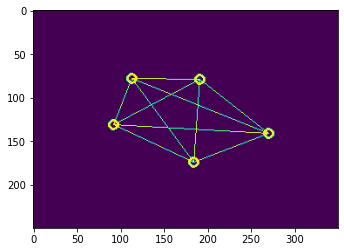

In [ ]:
plt.imshow(black)

## The `distance_matrix`

This matrix visualizes the distance between every "node" in form of a square matrix. Notice how the matrix is symmetric because the distance between node A and node  is the same as node B to A. 

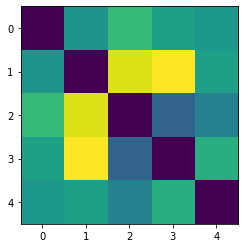

In [ ]:
plt.imshow(distance_matrix)

## Scaling up the process for all the images 

If you want to visualize the nodes on a black image instead of the segmented contours, you can uncomment the `black = np.zeros(sg.shape)` line and comment out the `black = sg` line. 

In [ ]:
def make_node_map(image_path):
    sg, centroids = model.predict(image_path, centroid_mode= True)
    # black = np.zeros(sg.shape)
    black = sg
    real = cv2.imread(image_path,0)

    distance_matrix = np.zeros((len(centroids),len(centroids)))

    for i in range(len(centroids)):
        black = cv2.circle(black, centroids[i], 5, thickness = 2, color = (255,255,255))
        # black = cv2.putText(black, str(i), centroids[i], fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color = (255,255,255))

    for m in range(len(centroids)):
        main = centroids[m]
        for n in range(len(centroids)):
            black = cv2.line(black, main, centroids[n], color = 255, thickness = 1)
            distance_matrix[m][n] = distance.euclidean(main, centroids[n])

    
    return real ,black, distance_matrix

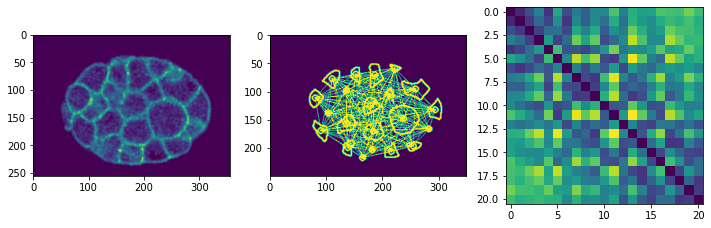

In [ ]:
real, nodes , map = make_node_map(image_paths[50])

fig, ax = plt.subplots(1,3, figsize = (12,15))

ax.flat[0].imshow(real)
ax.flat[1].imshow(nodes)
ax.flat[2].imshow(map)

## Creating an animation to better visualize the node maps

All the frames would be saved in the `animation` folder

In [ ]:
!rm -rf animation
!mkdir animation

In [ ]:
count = 0
for path in image_paths:
    print(path)

    real, nodes,map = make_node_map(path)

    fig, ax = plt.subplots(1,3, figsize = (12,5))

    ax.flat[0].imshow(real)
    ax.flat[1].imshow(nodes)
    ax.flat[2].imshow(map)


    ax.flat[0].set_xlabel('real', fontsize = 15)
    ax.flat[1].set_xlabel('node map', fontsize = 15)
    ax.flat[2].set_xlabel('distance matrix', fontsize = 15)


    
    clear_output(wait = True)
    fig.savefig("animation/" + str(count) + ".jpg")
    count += 1

In [ ]:
from PIL import Image

In [ ]:
names = [ "animation/" + str(i) + ".jpg" for i in range (0, count, 1)]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

95


In [ ]:
images[0].save('nodes_matrix_long_smooth.gif',
               save_all=True,
               append_images=images[1:],
               duration=150,
               loop=0)

## Saving the extracted centroids into a CSV file 

In [ ]:
centroids = []
for i in range(len(image_paths)):
    sg, centroid = model.predict(image_paths[i], centroid_mode= True)
    centroids.append([centroid])


In [ ]:
df = pd.DataFrame(centroids)

In [ ]:
df.columns = ["centroids (x, y)"]

In [ ]:
df.head()

,"centroids (x, y)"
0,"[(184, 174), (270, 141), (113, 78), (92, 131),..."
1,"[(112, 198), (183, 175), (271, 140), (91, 129)..."
2,"[(184, 180), (271, 140), (90, 126), (191, 82)]"
3,"[(91, 179), (182, 185), (273, 140), (92, 124),..."
4,"[(178, 186), (273, 138), (93, 123), (198, 89)]"


In [ ]:
df.to_csv("c_elegans_centroids.csv")

# Moving on towards the next objective

i.e  trying to make a 3d model of the C. elegans embryo using images from n different planes of the same embryo

In [ ]:
df = pd.read_csv("metadata.csv")
image_paths  = df[df["image"].str.contains("real_45") == True]["image"].unique()

In [ ]:
centroids = []
for i in range(len(image_paths)):
    sg, centroid = model.predict(image_paths[i], centroid_mode= True)
    centroids.append(centroid)

In [ ]:
centroids = np.array(centroids)

## Mapping the centroids into a 3d plot for visualization

For our case, we do not use all the centroids, this was done in order regulate the density of the scatterplot. Try tweaking the step size in the for loop for a denser plot. 

In [397]:
x_s = []
y_s = []
z_s = []

for i in range(0,len(centroids),15):
    x,y = [list(c) for c in zip(*centroids[i])]
    z = np.ones(len(x))*i

    x_s.extend(x)
    y_s.extend(y)
    z_s.extend(z)

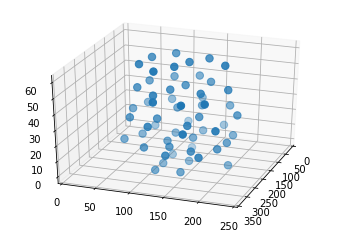

In [399]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, 350)
ax.set_ylim(0, 250)

ax.scatter(x_s,y_s,z_s, cmap = "jet", marker = "o", s = 55)
ax.view_init(30, 20)


## Making an animation 

The animation would help us visualize the 3d node map from different angles. 

In [ ]:
from matplotlib import animation

In [394]:
def rotate(angle):
    ax.view_init(elev = angle//5, azim=angle)  ## x y plane angle 

    if angle < 100:
        ax.set_zlim(0, int((angle/100) * 90)) ## z elevation upto 100th frame

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,150,1),interval=75)
rot_animation.save('3d_node_map.gif', dpi=80, writer='pillow')